## Spatial dynamics

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import  solve_ivp
from scipy.special import erf
from math import sqrt
from scipy.ndimage import laplace, convolve1d

In [5]:
def calc_t_half(N0, Ncrit, K, r_d, p_p, s_p):
    return Ncrit * N0*(2 * K * Ncrit - N0**2)/(r_d * p_p * s_p * (4 * K**2 * Ncrit**2 - 6 * K**2 * Ncrit * N0 + 2 * K**2 * N0**2 - 6 * K * Ncrit**2 * N0 + 9 * K * Ncrit * N0**2 - 3 * K * N0**3 + 2 * Ncrit**2 * N0**2 - 3 * Ncrit * N0**3 + N0**4))

def calc_t_r_d(K, r_b, r_d, p_d, p_p, s_p, s_d):
    return (K*r_b*r_d*p_d*s_d**2 - K*r_d**2*p_d*s_d**2 + r_b**3*p_p*s_p - r_b**2*r_d*p_p*s_p)/(r_d*p_p*s_p*(-K*r_b*p_d*s_d**2 + K*r_d*p_d*s_d**2 + r_b**2*p_p*s_p))

def calc_t_half_naive(r_b, r_d, p_p, s_p):
    return (r_b - r_d) / (r_d * p_p * s_p)


In [6]:
# cancer params
r_d = 0.25
r_b = 0.5
a_max = 1
# p_mut = 1
p_l = 1e-8
T_d = 700
# T_d = 1400
T_p = 5e6
# T_p = 1e7
p_d = T_d * p_l
p_p = T_p * p_l
p_mut = 1 - (1 - p_d) * (1 - p_p)
p_pos = T_d / (T_d + T_p)
s_p = 0.001 * r_b
s_d = 0.2 * r_b
tmax = 100000
# Da = var / 2
dens0 = 1 - r_d / r_b
# mean_mut_effect = p_pos * s_d - (1 - p_pos) * s_p
# var = p_pos * s_d**2 + (1 - p_pos) * s_p**2
# secondmommu = var + mean_mut_effect**2
Ncrit = T_p * (s_p / r_b) / T_d / (s_d/r_b)**2
mucrit = s_d / T_p / r_b

L0 = 1
K = round(np.ceil(Ncrit / 2 / L0))
N0 = dens0 * K
l = round(np.ceil(8 * Ncrit / K))
# t_half = calc_t_half(N0*L0, Ncrit, K*L0, r_d, p_p, s_p/r_b)
t_half = calc_t_half_naive(r_b, r_d, p_p, s_p)
# t_half_naive = 1 / r_d**(N0/2)
vcrit = L0 / t_half * 2
# vtarget = vcrit * 4
vtarget = 1e-1
# gamma = -np.log(vtarget**2 / (4 * (r_b - r_d)))
gamma = 13
# gamma = np.log(t_half * N0)  # approximate gamma value
D = 1. / (2 + np.exp(gamma))
Tfill = l / (2 * np.sqrt(D * (r_b - r_d)))
print(Tfill, t_half, gamma, vcrit)

10642.29018370969 40000.0 13 5e-05


estimation of invasion speed.
p_v = 1 / (2 + exp(gamma)) # probability of migration
P(no invasion per time step | N cells) = (1 - p_v)^N = p_b approx 1 - p_v * N
P(invasion per time step | N cells) = 1 - p_b = p_I
mean time for invasion = 1 / p_I = t_half
t_half = 1 / (1 - p_b) = 1 / (1 - (1 - p_v)^N) = 1 / (1 - (1 - (1 / (2 + exp(gamma))))^N) = t_half approx 1 / (1 - (1 - N / ( 2 + exp(gamma))))
1 / t_half = 1 - (1 - (2 + exp(gamma))^-N)
1 - 1 / t_half = 1 - (2 * exp(gamma))^-N
(2 * exp(gamma))^-N = 1 / t_half

 

In [7]:
Ncrit

178.57142857142856

In [172]:
# ks = np.arange(1, 2 * Ncrit-1)
# n0s = dens0 * ks
# plt.plot(n0s, calc_t_half(n0s, Ncrit, ks, r_d, p_p, s_p/r_b))
# plt.vlines(Ncrit, 0, 1e8, 'k', '--')
# plt.yscale('log')
# plt.xlabel('initial cell number')

In [173]:
tmax = 40000
dims= l,
nodes = np.zeros((l, 3), dtype=int)
nodes[:L0, -1] = N0
lgca = get_lgca(ib=True, nodes=nodes, bc='refl', interaction='birthdeath_cancerdfe', ve=False, capacity=K,
                r_d=r_d, r_b=r_b, a_max=a_max, geometry='lin', dims=dims, restchannels=1, s_d=s_d, p_d=p_d, p_p=p_p, s_p=s_p, gamma=gamma)
lgca.timeevo(timesteps=tmax, record=True)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [174]:
# calculate a skip value to only 100 time points
skip = int(np.ceil(tmax / 400))
lgca.dens_t.astype(bool).shape

(40001, 16)

(1, 16986.464646342472)

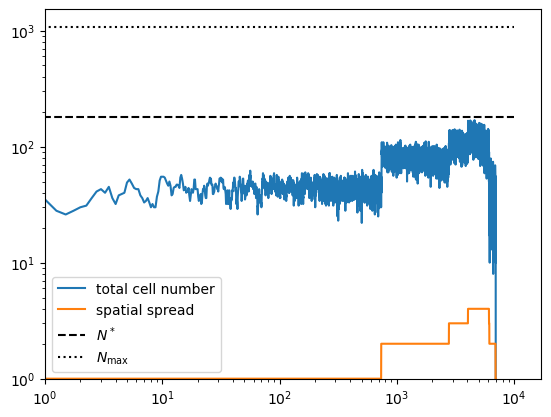

In [175]:
skip=1
x = np.arange(tmax+1)[::skip] / 4
plt.plot(x, lgca.dens_t.sum(-1)[::skip], label='total cell number')
# plot the number of nonzero nodes
plt.plot(x, lgca.dens_t.astype(bool).sum(-1)[::skip], label='spatial spread')
Nmax = K * (1 - r_d) * l
plt.plot([0, tmax/4], [Ncrit, Ncrit], 'k--', label='$N^*$')
plt.plot([0, tmax/4], [Nmax, Nmax], 'k:', label=r'$N_{\max}$')
plt.yscale('log')
plt.ylim(1)
plt.legend()
#plt.vlines(t_half, 1, 2e3)
plt.loglog()
plt.xlim(1)

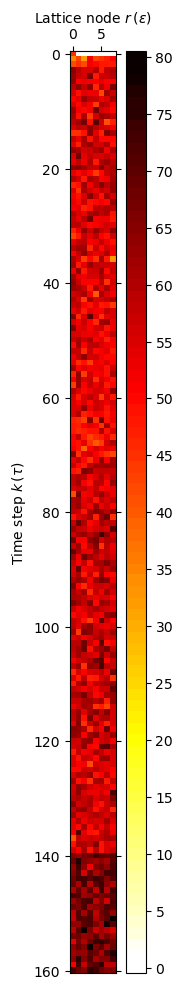

In [101]:
lgca.plot_density(density_t=lgca.dens_t[::skip])

([<matplotlib.lines.Line2D at 0x2389b368090>],
 <matplotlib.collections.PolyCollection at 0x2389b305150>)

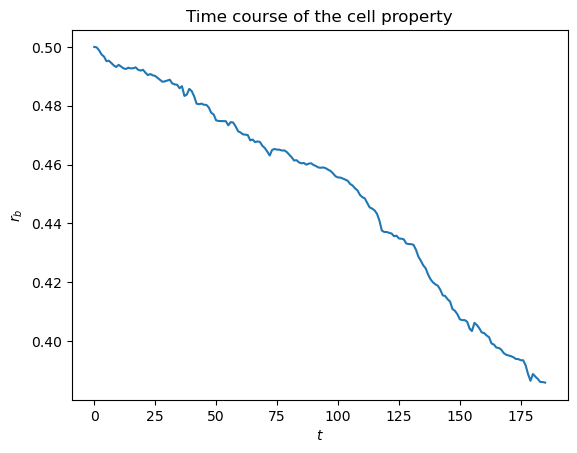

In [68]:
lgca.plot_prop_timecourse(nodes_t=lgca.nodes_t[::skip])

In [95]:
print(np.sum(lgca.nodes_t.astype(bool)))

In [93]:
lgca.plot_prop_spatial(nodes_t=lgca.nodes_t[::skip])